In [46]:
from models import TSP
import numpy as np
import networkx as nx
import random

from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from scipy.linalg import circulant

In [187]:
class GlobGraph:
    def __init__(self, n):
        #this is just a dummy class to try out stuff
        # construct a graph that has all the nodes and informations for dynamics tsp
        # --> O(n!) nodes, tree like structure except for the leaves, which are connected to the root
        self.n = n
        self.G = self.create_tree()
        self.adj = nx.adjacency_matrix(self.G).toarray()
        self.node_num = self.G.number_of_nodes()
        self.draw()
    def create_tree(self, low=1, high=10):
        G = nx.empty_graph(1)
        prev_level = [0]
        k = self.n-1
        while k > 1:
            idx = prev_level[-1] #get highest index node
            curr_level = []
            for i in prev_level:
                for j in range(k):
                    idx += 1
                    G.add_node(idx)
                    G.add_edge(idx, i, weight=random.randint(1,10))
                    curr_level.append(idx)
            prev_level = curr_level
            k -= 1
        #join ends
        for i in prev_level:
            G.add_edge(i, 0, weight=random.randint(1,10))
        return G
    def draw(self):
        import matplotlib.pyplot as plt
        pos = nx.spring_layout(self.G, seed=8)  # positions for all nodes - seed for reproducibility

        # nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=400)

        # edges
        nx.draw_networkx_edges(self.G, pos, edgelist=self.G.edges, width=5)

        # node labels
        nx.draw_networkx_labels(self.G, pos, font_size=20, font_family="sans-serif")
        # edge weight labels
        edge_labels = nx.get_edge_attributes(self.G, "weight")
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels)

        ax = plt.gca()
        ax.margins(0.08)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

In [188]:
class DTSP(TSP):
    def __init__(self, globgraph, A=500, B=500, C=200, D=1):
        self.adj = globgraph.adj
        self.weight_penalty = 100
        #adjusting adj
        for i in range(self.adj.shape[0]):
            for j in range(self.adj.shape[1]):
                if self.adj[i,j] == 0:
                    self.adj[i,j] = self.weight_penalty
        #print(self.adj)
        self.n = globgraph.node_num
        self.og_n = globgraph.n-1
        self.I = 2*C * (self.og_n) * np.ones(self.n*self.og_n)
        self.A = A
        self.B = B
        self.C = C
        self.D = 2*D
        self.offset = C * self.og_n**2
        self.T = self.compute_T()
        
    def circulant_matrix(self):
        first_column = np.zeros(self.og_n)
        first_column[1] = 1
        first_column[-1] = 1
        return circulant(first_column)
    
    def comm_mat(self, m, n):
        w = np.arange(m * n).reshape((m, n), order="F").T.ravel(order="F")
        return np.eye(m * n)[w, :]
    
    #need to make this more general
    def compute_T(self):
        #T should be of size (self.n*self.og_n)x(self.n*self.og_n)
        Id = np.eye(self.n)
        J = 1-np.eye(self.og_n)
        M1 = np.kron(Id, J)
        Phi = self.comm_mat(self.og_n, self.n)
        M2_tmp = np.kron(np.eye(self.og_n), 1-np.eye(self.n))
        M2 = Phi.T@(M2_tmp@Phi)
        alpha_matrix = self.circulant_matrix()
        M3 = np.kron(self.adj,alpha_matrix)
        M4 = np.ones((self.n*self.og_n, self.n*self.og_n))
        T = -self.A*M1 -self.B*M2 -self.C*2*M4 - self.D*0.5*M3
        return (M1, M2, M3, self.C*2*M4, T, None)
    
    def interpret(self, solution):
        sol = solution.copy().reshape((self.n, self.og_n))
        print(sol)
        # Check the structure first
        rows, cols = np.nonzero(sol)
        for i in range(len(rows)-1):
            if rows[i] in rows[i+1:]:
                print("Non-legal solution!")
                return
        for i in range(len(cols)-1):
            if cols[i] in cols[i+1:]:
                print("Non-legal solution!")
                return
        # Try to interpret the solution by taking the max of each row and clipping all values below to zero
        idxs = []
        for i in range(self.n):
            row = sol[i,:]
            max_val = np.max(row)
            row[row<max_val] = 0
            if max_val != 0:
                row[row == max_val] = 1
                max_idx = np.argmax(row)
                idxs.append((i,max_idx))
            sol[i,:] = row
        
        sorted_idxs = sorted(idxs, key=lambda x: x[1])
        
        result = [x[0] for x in sorted_idxs]
        return result
    def get_cost(self, solution):
        sol = self.interpret(solution)
        tour_length = 0
        for i in range(len(sol)-1):
            tour_length += self.adj[int(sol[i]), int(sol[i+1])]
        tour_length += self.adj[int(sol[-1]), int(sol[0])]
        return tour_length

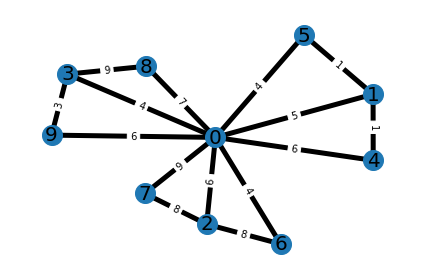

10

In [205]:
G = GlobGraph(4)
G.G.number_of_nodes()

In [206]:
problem = DTSP(G, A=500, B=500, C=200, D=1)

In [207]:
from scipy.optimize import dual_annealing
from models import HopfieldNetwork

In [208]:
hopfield = HopfieldNetwork(problem.T, problem.I, problem.offset)

In [209]:
import numpy as np
from gurobipy import Model, GRB, QuadExpr
problem = DTSP(G, A=500, B=500, C=200, D=1)
# Define the interaction matrix (Q) and field vector (c)
Q = problem.T[-2] # Interaction matrix
c = problem.I # Field vector

# Create a new Gurobi model
model = Model("Qua")

# Add binary variables
n = Q.shape[0]
var = [model.addVar(vtype=GRB.BINARY, name=f"x{i}") for i in range(n)]

# Set up the quadratic objective
objective = QuadExpr()

# Add quadratic terms from Q
for i in range(n):
    for j in range(n):
        if Q[i, j] != 0:
            objective.add(-0.5*Q[i, j] * var[i] * var[j])

# Add linear terms from c
for i in range(n):
    if c[i] != 0:
        objective.add(-c[i] * var[i])

        
objective.addConstant(problem.offset)

# Set the objective
model.setObjective(objective, GRB.MINIMIZE)

# Optimize the model
model.optimize()


gurobi_solution = []
# Display results
if model.status == GRB.OPTIMAL:
    print("Optimal value:", model.objVal)
    for v in var:
        print(f"{v.varName} = {v.x}")
        gurobi_solution.append(v.x)
else:
    print("No optimal solution found.")

    
print(problem.interpret(np.array(gurobi_solution)))
print(hopfield.compute_energy(np.array(gurobi_solution), debug=True))

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 30 columns and 0 nonzeros
Model fingerprint: 0xab6fed52
Model has 465 quadratic objective terms
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+03, 1e+03]
  QObjective range [4e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 1800.0000000
Found heuristic solution: objective 18.0000000
Found heuristic solution: objective 10.0000000
Presolve time: 0.00s
Presolved: 435 rows, 465 columns, 1305 nonzeros
Variable types: 0 continuous, 465 integer (465 binary)

Root relaxation: objective -1.320000e+04, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 